# Task 3: Model Development
We will try to predict the categories of our future customers.
We will use HistGradientBoostingClassifier, since we already used it in the practice notebool, but I kinda want to explore other models and see what I can come up with.

Most of the code will be referenced from [INRIA's Course](https://inria.github.io/scikit-learn-mooc/) on Machine Learing with Scikit-Learn.

## 3.1. Data Preparation
- Lets just import our data first.
- Then we can note down the common test and train columns.
- Then we will engineer the features on the test data.

In [156]:
# Import the Postcoded dataset
import pandas as pd
import numpy as np

Train = pd.read_csv("Postcoded.csv")

NewCustomerList = pd.read_csv("NewCustomerList.csv")

In [157]:
pos_cols = Train.columns
print(pos_cols)

new_cols = NewCustomerList.columns
print(new_cols)

common_cols = pos_cols.intersection(new_cols)
print(common_cols)

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'country',
       'property_valuation', 'lat', 'long', 'state', 'customer_age',
       'product_age', 'age_group', 'profit', 'recency', 'frequency',
       'transaction_day', 'transaction_week', 'transaction_month', 'cluster',
       'customer_category', 'nearest_point', 'distance_to_coast'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'ad

We'll be engineering the following features in the test data:
- customer_age
- age_group
- lat, long
- distance_to_coast

So basically we will only be expanding the DOB and postcode columns.
Lets also try and multiply the property_valuation with the tenure, that might do something.

## 3.2. Engineering the Features

### 3.2.1. Customer Age Features

In [158]:
# Building the customer_age column
end_date = pd.to_datetime("2017-12-30")
NewCustomerList["DOB"] = pd.to_datetime(NewCustomerList["DOB"])

NewCustomerList["customer_age"] = (end_date - NewCustomerList["DOB"]).dt.days // 365.25
NewCustomerList["customer_age"] = NewCustomerList["customer_age"].astype("Int64")

# Keeping only the customers between 14 and 100 years old
NewCustomerList = NewCustomerList[NewCustomerList["customer_age"].between(14, 100)]

In [159]:
# Calculating the age_group column
age_group = pd.cut(
    NewCustomerList["customer_age"],
    bins=[14,30,50,70,90],
    labels=["14-30","30-50","50-70","70-90"]
)

NewCustomerList["age_group"] = age_group

### 3.2.2. Customer Coordinate Features

In [160]:
# Importing the postcode dataset

Postcodes = pd.read_csv("/home/meow/Desktop/internship-speedrun/kpmg/australian_postcodes.csv")

# Replace 0 with NaN
Postcodes.replace(0, np.nan, inplace=True)

In [161]:
# We only need the postcode, longitude and latitude columns
# We also need the state column which will make the state consistent with postcodes in the MasterDataset

Postcodes = Postcodes[["postcode", "lat", "long", "state"]]

In [162]:
# Drop all the rows with missing values
Postcodes.dropna(inplace=True)

# Drop all the duplicate rows
Postcodes.drop_duplicates(inplace=True)

# Drop all the non unique postcode rows
Postcodes.drop_duplicates(subset="postcode", inplace=True)

Postcodes.head()

,postcode,lat,long,state
0,200,-35.277700,149.119000,ACT
2,800,-12.458684,130.836680,NT
4,801,-12.458684,130.836680,NT
6,804,-12.428017,130.873315,NT
7,810,-12.381806,130.866242,NT


In [163]:
Postcoded = NewCustomerList.copy()

Postcoded = pd.merge(
    Postcoded,
    Postcodes,
    how="inner",
    left_on="postcode",
    right_on="postcode",
)

In [164]:
print(Postcoded.shape)
print(NewCustomerList.shape)

(983, 23)
(983, 20)


In [165]:
# Since state_y is a feature of postcode it is more reliable than state_x
# So we will drop state_x

Postcoded.drop(columns="state_x", inplace=True)
Postcoded.rename(columns={"state_y": "state"}, inplace=True)

In [166]:
Postcoded.sample(5)

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,country,property_valuation,Rank,Value,customer_age,age_group,lat,long,state
241,Isadora,Ducker,F,15,1973-08-25,Account Executive,NaN,Affluent Customer,False,True,8,2972 Holy Cross Crossing,3153,Australia,5,386,0.945625,44,30-50,-37.845116,145.270141,VIC
415,Franklin,Wohler,M,55,1938-10-16,Clinical Specialist,Health,Mass Customer,False,True,7,6966 Delladonna Street,2250,Australia,8,191,1.150000,79,70-90,-33.325373,151.189243,NSW
454,Seymour,Fellibrand,M,28,1971-10-11,Structural Analysis Engineer,NaN,Affluent Customer,False,True,18,96081 Lakewood Hill,4650,Australia,2,708,0.680000,46,30-50,-25.640978,152.791302,QLD
214,Patricia,Everix,F,34,1978-02-19,Director of Sales,Health,Mass Customer,False,False,19,91164 Washington Terrace,2263,Australia,7,89,1.312500,39,30-50,-33.285097,151.556223,NSW
54,Nanni,Girodias,F,61,1959-01-08,NaN,Retail,High Net Worth,False,False,16,74 Shopko Pass,2161,Australia,9,617,0.754375,58,50-70,-33.858335,150.983724,NSW


### 3.2.3. Customer Distance to Coast Features

In [167]:
from shapely.ops import nearest_points, Point
import haversine as hs
from haversine import Unit
import geopandas as gpd

def coastline_minima(df, lat_col, long_col, country):
    """
    This function takes in a dataframe with latitude and longitude columns and returns the nearest point on the coastline and the distance in km

    Required libraries: geopandas, shapely, folium, haversine
    Returns: original dataframe with two new columns: nearest_point and distance_to_coast

    """
    # Getting the coastline
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    coastline = world[world.name.str.contains(country)].boundary

    # Creating empty lists to store the nearest point and the distance
    nearest_points_list = []
    distance_list = []

    for i in range(len(df)):
        geo = Point(df[long_col][i], df[lat_col][i])
        nearest = nearest_points(geo, coastline)[1]
        cos = Point(nearest.x, nearest.y)
        loc1 = (geo.y, geo.x)
        loc2 = (cos.y, cos.x)
        result = hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)

        nearest_points_list.append(nearest)
        distance_list.append(result)

    # Adding the new columns to the dataframe
    df["nearest_point"] = nearest_points_list
    df["distance_to_coast"] = distance_list

    return df


In [168]:
coastline_minima(Postcoded, "lat", "long", "Australia")

/tmp/ipykernel_12371/197697157.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,country,property_valuation,Rank,Value,customer_age,age_group,lat,long,state,nearest_point,distance_to_coast
0,Chickie,Brister,M,86,1957-07-12,General Manager,Manufacturing,Mass Customer,False,True,14,45 Shopko Center,4500,Australia,6,1,1.71875,60,50-70,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656
1,Peria,Rantoull,F,3,1975-03-13,Financial Analyst,Financial Services,Mass Customer,False,False,4,8350 Moulton Terrace,4500,Australia,4,120,1.26250,42,30-50,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656
2,Madison,Lars,M,11,1967-01-19,Health Coach III,Health,Mass Customer,False,False,19,9503 New Castle Street,4500,Australia,9,620,0.75000,50,30-50,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656
3,Andrea,Pendle,F,86,1938-08-05,NaN,NaN,High Net Worth,False,True,13,31281 Meadow Valley Way,4500,Australia,6,760,0.63750,79,70-90,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656
4,Philbert,Bangs,M,67,1966-03-03,Environmental Specialist,IT,Mass Customer,False,True,6,02643 Moose Court,4500,Australia,7,951,0.45050,51,50-70,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Lauralee,Fudge,F,83,1987-09-21,Research Nurse,Health,Mass Customer,False,False,15,9460 Monument Park,3277,Australia,4,985,0.40800,30,14-30,-38.389835,142.660221,VIC,137 POINT (142.62795 -38.50549) dtype: geom...,13.163628
979,Weidar,Etheridge,M,38,1959-07-13,Compensation Analyst,Financial Services,Mass Customer,False,True,6,0535 Jay Point,2422,Australia,4,994,0.38250,58,50-70,-31.973082,151.865806,NSW,137 POINT (152.56524 -32.31264) dtype: geom...,75.908758
980,Datha,Fishburn,F,15,1990-07-02,Office Assistant IV,Retail,Mass Customer,False,False,3,6 Caliangt Way,3079,Australia,12,994,0.38250,27,14-30,-37.772675,145.048573,VIC,137 POINT (145.03221 -37.89619) dtype: geom...,13.808972
981,Melloney,Temby,F,17,1954-10-05,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,False,True,15,33475 Fair Oaks Junction,4702,Australia,2,997,0.35700,63,50-70,-23.279639,150.885772,QLD,137 POINT (150.87028 -23.28216) dtype: geom...,1.606935


### 3.2.4. Customer Property Valuation Features

In [169]:
# Multiplying the valuation to the tenure

Postcoded["tenure_valuation_mul"] = Postcoded["tenure"] * Postcoded["property_valuation"]

# Dividing the valuation by the tenure

Postcoded["tenure_valuation_div"] = Postcoded["tenure"] / Postcoded["property_valuation"]

In [170]:
# Same for the train dataset

Train["tenure_valuation_mul"] = Train["tenure"] * Train["property_valuation"]
Train["tenure_valuation_div"] = Train["tenure"] / Train["property_valuation"]

### 3.2.5. Adding a potential_customer_id column

In [171]:
# Adding a potential_customer_id column

Postcoded["potential_customer_id"] = Postcoded.index + 1

In [172]:
Postcoded

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,country,property_valuation,Rank,Value,customer_age,age_group,lat,long,state,nearest_point,distance_to_coast,tenure_valuation_mul,tenure_valuation_div,potential_customer_id
0,Chickie,Brister,M,86,1957-07-12,General Manager,Manufacturing,Mass Customer,False,True,14,45 Shopko Center,4500,Australia,6,1,1.71875,60,50-70,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656,84,2.333333,1
1,Peria,Rantoull,F,3,1975-03-13,Financial Analyst,Financial Services,Mass Customer,False,False,4,8350 Moulton Terrace,4500,Australia,4,120,1.26250,42,30-50,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656,16,1.000000,2
2,Madison,Lars,M,11,1967-01-19,Health Coach III,Health,Mass Customer,False,False,19,9503 New Castle Street,4500,Australia,9,620,0.75000,50,30-50,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656,171,2.111111,3
3,Andrea,Pendle,F,86,1938-08-05,NaN,NaN,High Net Worth,False,True,13,31281 Meadow Valley Way,4500,Australia,6,760,0.63750,79,70-90,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656,78,2.166667,4
4,Philbert,Bangs,M,67,1966-03-03,Environmental Specialist,IT,Mass Customer,False,True,6,02643 Moose Court,4500,Australia,7,951,0.45050,51,50-70,-27.307845,152.939438,QLD,137 POINT (153.09291 -27.26030) dtype: geom...,16.061656,42,0.857143,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Lauralee,Fudge,F,83,1987-09-21,Research Nurse,Health,Mass Customer,False,False,15,9460 Monument Park,3277,Australia,4,985,0.40800,30,14-30,-38.389835,142.660221,VIC,137 POINT (142.62795 -38.50549) dtype: geom...,13.163628,60,3.750000,979
979,Weidar,Etheridge,M,38,1959-07-13,Compensation Analyst,Financial Services,Mass Customer,False,True,6,0535 Jay Point,2422,Australia,4,994,0.38250,58,50-70,-31.973082,151.865806,NSW,137 POINT (152.56524 -32.31264) dtype: geom...,75.908758,24,1.500000,980
980,Datha,Fishburn,F,15,1990-07-02,Office Assistant IV,Retail,Mass Customer,False,False,3,6 Caliangt Way,3079,Australia,12,994,0.38250,27,14-30,-37.772675,145.048573,VIC,137 POINT (145.03221 -37.89619) dtype: geom...,13.808972,36,0.250000,981
981,Melloney,Temby,F,17,1954-10-05,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,False,True,15,33475 Fair Oaks Junction,4702,Australia,2,997,0.35700,63,50-70,-23.279639,150.885772,QLD,137 POINT (150.87028 -23.28216) dtype: geom...,1.606935,30,7.500000,982


## 3.3. Consistency and Encoding

### 3.3.1. Checking the consistency of the train and test data
- We will store the training data in a dataframe called `data`.
- We will also drop all the columns that might add a leakage to the model.

In [173]:
# display all columns pandas
pd.set_option("display.max_columns", None)
train_df_all = Train.copy()
test_df_all = Postcoded.copy()

In [174]:
# Dropping the columns that arent numerical or categorical
test_df = test_df_all.drop(['nearest_point', 'first_name', 'last_name', 'address', 'country', 'postcode', 'DOB'], axis=1)

In [175]:
# Getting the common columns
common_cols = train_df_all.columns.intersection(test_df.columns)
print(common_cols)
print(len(common_cols))

Index(['gender', 'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'property_valuation', 'lat', 'long', 'state',
       'customer_age', 'age_group', 'distance_to_coast',
       'tenure_valuation_mul', 'tenure_valuation_div'],
      dtype='object')
17


In [176]:
# Drop all the columns that arent common but keep customer_category
cols = [
    "gender",
    "past_3_years_bike_related_purchases",
    "job_title",
    "job_industry_category",
    "wealth_segment",
    "deceased_indicator",
    "owns_car",
    "tenure",
    "property_valuation",
    "lat",
    "long",
    "state",
    "customer_age",
    "age_group",
    "distance_to_coast",
    "tenure_valuation_mul",
    "tenure_valuation_div",
    "customer_category",
]

data = train_df_all[cols]

### 3.3.2. Target Variable and Encoding

In [177]:
# Defining the target variable

target_name = "customer_category"
target = data[target_name]

data = data.drop(columns=target_name)


### 3.3.3. Numerical and Categorical Features

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19513 entries, 0 to 19512
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               19513 non-null  object 
 1   past_3_years_bike_related_purchases  19513 non-null  int64  
 2   job_title                            17173 non-null  object 
 3   job_industry_category                16291 non-null  object 
 4   wealth_segment                       19513 non-null  object 
 5   deceased_indicator                   19513 non-null  bool   
 6   owns_car                             19513 non-null  bool   
 7   tenure                               19513 non-null  int64  
 8   property_valuation                   19513 non-null  int64  
 9   lat                                  19513 non-null  float64
 10  long                                 19513 non-null  float64
 11  state                       

In [179]:
# Converting all the boolean columns to object type

bool_cols = data.columns[data.dtypes.eq("bool")]
data[bool_cols] = data[bool_cols].astype("object")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19513 entries, 0 to 19512
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               19513 non-null  object 
 1   past_3_years_bike_related_purchases  19513 non-null  int64  
 2   job_title                            17173 non-null  object 
 3   job_industry_category                16291 non-null  object 
 4   wealth_segment                       19513 non-null  object 
 5   deceased_indicator                   19513 non-null  object 
 6   owns_car                             19513 non-null  object 
 7   tenure                               19513 non-null  int64  
 8   property_valuation                   19513 non-null  int64  
 9   lat                                  19513 non-null  float64
 10  long                                 19513 non-null  float64
 11  state                       

In [180]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
category_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
category_columns = category_columns_selector(data)

# Print the lengths of numerical_columns, category_columns, and data.columns
print(f"Number of numerical columns: {len(numerical_columns)}")
print(f"Number of categorical columns: {len(category_columns)}")
print(f"Total number of columns: {len(data.columns)}")

Number of numerical columns: 9
Number of categorical columns: 8
Total number of columns: 17


## 3.4 Building a Logistic Regression Model

In [181]:
# One-hot encoding the categorical columns and standardizing the numerical columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [182]:
# Creating the Transformer and preprocessor object
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [
        ("cat-preprocessor", categorical_preprocessor, category_columns),
        ("num-preprocessor", numerical_preprocessor, numerical_columns),
    ]
)

In [183]:
# Building a model with a pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model_1 = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
model_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat-preprocessor',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'job_title',
                                                   'job_industry_category',
                                                   'wealth_segment',
                                                   'deceased_indicator',
                                                   'owns_car', 'state',
                                                   'age_group']),
                                                 ('num-preprocessor',
                                                  StandardScaler(),
                                                  ['past_3_years_bike_related_purchases',
                                                   'tenure',
                                                   'property_valuation', 'lat',
                                                   'long', 'customer_age',
                                                   'distance_to_coast',
                                                   'tenure_valuation_mul',
                                                   'tenure_valuation_div'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [184]:
# Making the train-test split

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

In [185]:
_ = model_1.fit(data_train, target_train)

In [186]:
data_test.head()


,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,property_valuation,lat,long,state,customer_age,age_group,distance_to_coast,tenure_valuation_mul,tenure_valuation_div
9530,F,60,Administrative Officer,Financial Services,High Net Worth,False,False,12,7,-37.869072,144.999026,VIC,38,31-50,3.973526,84,1.714286
385,M,68,Financial Analyst,Financial Services,Mass Customer,False,False,3,10,-33.731523,150.931074,NSW,36,31-50,38.424585,30,0.300000
15307,M,56,Editor,Financial Services,Mass Customer,False,False,5,10,-37.744406,145.082685,VIC,41,31-50,17.449963,50,0.500000
4153,F,78,Quality Engineer,Financial Services,Affluent Customer,False,True,17,11,-33.732380,151.000948,NSW,43,31-50,32.667056,187,1.545455
8658,M,23,Librarian,Entertainment,Mass Customer,False,False,10,8,-33.783751,150.900547,NSW,48,31-50,38.026580,80,1.250000


In [187]:
model_1.predict(data_test)[:5]


array(['Gold', 'Gold', 'Silver', 'Gold', 'Gold'], dtype=object)

In [188]:
target_test[:5]

9530     Bronze
385        Gold
15307      Gold
4153       Gold
8658       Gold
Name: customer_category, dtype: object

In [189]:
model_1.score(data_test, target_test)

0.5316423264155777

In [190]:
# Evaluating the model with cross-validation
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model_1, data, target, cv=5)
cv_results

{'fit_time': array([3.53116274, 3.27520633, 4.48396277, 3.88765502, 3.39960694]),
 'score_time': array([0.01612687, 0.01691604, 0.03242636, 0.04653358, 0.0420053 ]),
 'test_score': array([0.46682039, 0.45836536, 0.46169613, 0.47514095, 0.46258329])}

In [191]:
# Getting the final score for our model

scores = cv_results["test_score"]

# Print mean cross-validation accuracy
print(f"Mean Accuracy: {scores.mean():.3f}")
print(f"Accuracy standard deviation: {scores.std():.3f}")

Mean Accuracy: 0.465
Accuracy standard deviation: 0.006


## 3.5 Building a HistGradientBoostingClassifier Model

In [192]:
# Making the train-test split

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

In [193]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("cat-preprocessor", categorical_preprocessor, category_columns)],
    remainder="passthrough",
)

model_2 = make_pipeline(preprocessor, HistGradientBoostingClassifier())

model_2


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['gender', 'job_title',
                                                   'job_industry_category',
                                                   'wealth_segment',
                                                   'deceased_indicator',
                                                   'owns_car', 'state',
                                                   'age_group'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [194]:
%%time
_ = model_2.fit(data_train, target_train)


CPU times: user 26.7 s, sys: 186 ms, total: 26.9 s
Wall time: 3.58 s


In [195]:
model_2.score(data_test, target_test)

0.9459390212656931

In [196]:
model_2.predict(data_test)[:10]

array(['Gold', 'Gold', 'Gold', 'Gold', 'Gold', 'Gold', 'Silver', 'Gold',
       'Gold', 'Gold'], dtype=object)

In [197]:
target_test[:10]

9530     Bronze
385        Gold
15307      Gold
4153       Gold
8658       Gold
6847       Gold
16879    Silver
16552      Gold
2112       Gold
12868      Gold
Name: customer_category, dtype: object

In [198]:
# Evaluating the model with cross-validation

from sklearn.model_selection import cross_validate

model_2_cv = cross_validate(model_2, data, target, cv=3)

# Getting the final score for our model

scores_2 = model_2_cv["test_score"]

# Print mean cross-validation accuracy
print(model_2_cv)
print(f"Mean Accuracy: {scores.mean():.3f}")
print(f"Accuracy standard deviation: {scores.std():.3f}")

{'fit_time': array([3.55521965, 1.74478197, 1.80755591]), 'score_time': array([0.0607574 , 0.07443833, 0.06538749]), 'test_score': array([0.45933897, 0.43388684, 0.4295818 ])}
Mean Accuracy: 0.465
Accuracy standard deviation: 0.006


## 3.6 Using GridSearchCV to find the best parameters

In [199]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

In [200]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

In [201]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

In [202]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

In [203]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['gender', 'job_title',
                                                   'job_industry_category',
                                                   'wealth_segment',
                                                   'deceased_indicator',
                                                   'owns_car', 'state',
                                                   'age_group'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [204]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: user 10.9 s, sys: 200 ms, total: 11.1 s
Wall time: 32 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['gender',
                                                                          'job_title',
                                                                          'job_industry_category',
                                                                          'wealth_segment',
                                                                          'deceased_indicator',
                                                                          'owns_car',
                                                                          'state',
                                                                          'age_group'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

In [205]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: {accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.95


In [206]:
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


In [207]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,4.207955,0.043758,0.117631,0.046231,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.893536,0.894219,0.893877,0.000342,1
4,1.693932,0.026523,0.155967,0.010307,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.734864,0.729807,0.732336,0.002528,2
2,6.659263,0.048238,0.109815,0.037286,0.01,30,"{'classifier__learning_rate': 0.01, 'classifie...",0.689080,0.669400,0.679240,0.009840,3
1,1.792381,0.022881,0.083117,0.004744,0.01,10,"{'classifier__learning_rate': 0.01, 'classifie...",0.565942,0.559519,0.562731,0.003212,4
7,1.258700,0.094601,0.143329,0.004096,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.581112,0.540249,0.560681,0.020432,5


## RandomSearchCV

In [208]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

In [209]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

In [210]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['gender', 'job_title',
                                                   'job_industry_category',
                                                   'wealth_segment',
                                                   'deceased_indicator',
                                                   'owns_car', 'state',
                                                   'age_group'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [211]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [212]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": loguniform_int(2, 256),
    "classifier__min_samples_leaf": loguniform_int(1, 100),
    "classifier__max_bins": loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    verbose=1,
    n_jobs=-1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


CPU times: user 37.6 s, sys: 1.04 s, total: 38.6 s
Wall time: 27.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['gender',
                                                                                'job_title',
                                                                                'job_industry_category',
                                                                                'wealth_segment',
                                                                                'deceased_indicator',
                                                                                'owns_car',
                                                                                'state',
                                                                                'age_group'])])),
                                             ('classifier',
                                              HistGr...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff26b380d90>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff2469801c0>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x7ff27762b850>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x7ff27762a110>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x7ff27762aaa0>},
                   verbose=1)

In [213]:
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is {accuracy:.2f}")

The test accuracy score of the best model is 0.99


In [214]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 8.345470368802708,
 'classifier__learning_rate': 0.9946611487089738,
 'classifier__max_bins': 104,
 'classifier__max_leaf_nodes': 255,
 'classifier__min_samples_leaf': 8}


In [239]:
# get the parameter names
column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False
)


def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
2,8.34547,0.994661,255,8,104,0.972940,0.002607,1
1,0.370407,0.527232,68,1,49,0.972940,0.001842,2
4,0.000046,0.310548,98,98,176,0.972392,0.004896,3
3,9.50623,0.012268,98,24,17,0.781537,0.006452,4
0,0.000007,0.838729,6,7,6,0.733503,0.068784,5


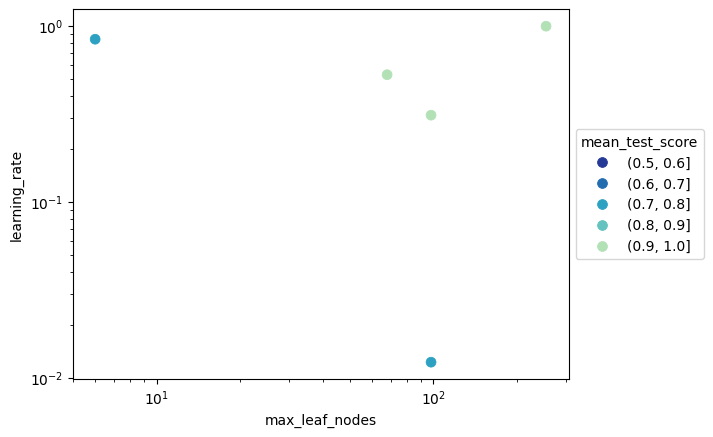

In [223]:
import seaborn as sns
import numpy as np

df = pd.DataFrame(
    {
        "max_leaf_nodes": cv_results["max_leaf_nodes"],
        "learning_rate": cv_results["learning_rate"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.5, 1.0, 6)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df,
    x="max_leaf_nodes",
    y="learning_rate",
    hue="score_bin",
    s=50,
    color="k",
    edgecolor=None,
)
ax.set_xscale("log")
ax.set_yscale("log")

_ = ax.legend(
    title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5)
)

In [242]:
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
2,8.34547,0.994661,255,8,104,0.972940,0.002607,1
1,0.370407,0.527232,68,1,49,0.972940,0.001842,2
4,0.000046,0.310548,98,98,176,0.972392,0.004896,3
3,9.50623,0.012268,98,24,17,0.781537,0.006452,4
0,0.000007,0.838729,6,7,6,0.733503,0.068784,5


In [251]:
import numpy as np
import plotly.express as px

# Rest of your code
log10_func = np.vectorize(np.log10)
log2_func = np.vectorize(np.log2)

fig = px.parallel_coordinates(
    cv_results.rename(shorten_param, axis=1).apply({
        "learning_rate": log10_func,
        "max_leaf_nodes": log2_func,
        "min_samples_leaf": log2_func,
        "max_bins": log10_func,
        "l2_regularization": log10_func,
        "mean_test_score": lambda x: x,
    }),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

In [252]:
# Print the best parameters
print(f"The best parameters are: {model_random_search.best_params_}")

The best parameters are: {'classifier__l2_regularization': 8.345470368802708, 'classifier__learning_rate': 0.9946611487089738, 'classifier__max_bins': 104, 'classifier__max_leaf_nodes': 255, 'classifier__min_samples_leaf': 8}
